In [16]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from scipy.ndimage import gaussian_filter1d
from scipy.stats import expon,gamma

import pandas as pd

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 17

from scipy.optimize import curve_fit


In [2]:
def autocorrelation(series,from_mean=True):
    """Compute the normalized autocorrelation function of a time series."""
    if from_mean:
        series = np.array(series) - np.mean(series)  # Remove mean
    else:
        series = np.array(series)
    n = len(series)
    norm = np.var(series) * n  # Normalization factor
    result = np.correlate(series, series, mode="full") / norm  # Compute autocorrelation
    return result[n-1:] / result[n-1:][0]

In [3]:
def projection(x,y,vx,vy):
    r = np.sqrt(x**2 + y**2)
    v = np.sqrt(vx**2 + vy**2)

    # Avoid division by zero
    r[r == 0] = np.nan
    v[v == 0] = np.nan

    # Compute projection
    projection = (x * vx + y * vy) / (r * v)
    projection[np.isnan(projection)] = 0
    
    
    return projection

def crossings(projection,t):
    sign_changes = np.where(np.sign(projection[:-1]) != np.sign(projection[1:]))[0]

    # Extract times at which the sign changes
    t_crossings = t[sign_changes]

    # Compute time intervals between consecutive crossings
    time_intervals = np.diff(t_crossings)
    return time_intervals


def displacement(x,y,step):
    dx = x[step:] - x[:-step]  # Difference in x
    dy = y[step:] - y[:-step]  # Difference in y

    displacements = np.sqrt(dx**2 + dy**2)
    
    return displacements

In [4]:
def find_zero_crossing_lag(acf):
    """Find the first zero crossing lag of the autocorrelation function."""
    indices = np.where(np.sign(acf[:-1]) != np.sign(acf[1:]))[0]
    return indices[0] + 1 if len(indices) > 0 else None


In [5]:
def mov_not_mov(A,th,zero_th=False):
    """
    Calculate moving and non moving steps.
    
    Parameters
    -----------
    A = array with the values to be analyzed, it can be the smoothed speed or the speed 
    
    th = threshold (taken from the prob of moving and prob of not moving)
    
    Return
    -------
    
    tuple: 
    
    (ns,ms,signal) = (list with NOT moving steps, list with MOVING steps,binary signal (+1 if this step and the next is above threshold, 0 if below))
     
    """
    
    # mask is an array that in each element has True if the value of array A is less than the threshold
    if zero_th:
        mask = A > th
        signal = [] # binary signal
        n=0 # counter for non moving steps
        m=0 # counter for moving steps
        ns=[] # list with consecutive non moving steps
        ms = [] # list with consecutive moving steps
        
        for i in range(len(A)-1):
            
            if mask[i] == False and mask[i+1] == False: # if this value in A and the next are below the threshold
                
                # print('n=',n)
                if m!=0: # append the current running value of m if we changed from moving to non moving
                    
                    ms.append(m)
                m=0 # reset the counter for moving steps
                signal.append(0) # append 0 to the signal
                n+=1 # begin counting non moving steps
            elif mask[i] == True or mask[i+1] == True: 
                # same as before but with the opposite condition
                if n!=0:
                    
                    ns.append(n)
                n=0
                signal.append(1)
                m+=1
            if i+1 == len(A)-1: 
                # if we are in the last element of A, we append the last values of n,m and the signal
                if mask[i] == False or mask[i+1] == False:
                    signal.append(0)
                    ns.append(n)
                else:
                    signal.append(1)
                    ns.append(m)
    else:
        mask = A <= th
        
        signal = [] # binary signal
        n=0 # counter for non moving steps
        m=0 # counter for moving steps
        ns=[] # list with consecutive non moving steps
        ms = [] # list with consecutive moving steps
        
        for i in range(len(A)-1):
            
            if mask[i] == True and mask[i+1] == True: # if this value in A and the next are below the threshold
                
                # print('n=',n)
                if m!=0: # append the current running value of m if we changed from moving to non moving
                    
                    ms.append(m)
                m=0 # reset the counter for moving steps
                signal.append(0) # append 0 to the signal
                n+=1 # begin counting non moving steps
            elif mask[i] == False or mask[i+1] == False: 
                # same as before but with the opposite condition
                if n!=0:
                    
                    ns.append(n)
                n=0
                signal.append(1)
                m+=1
            if i+1 == len(A)-1: 
                # if we are in the last element of A, we append the last values of n,m and the signal
                if mask[i] == False or mask[i+1] == False:
                    signal.append(1)
                    ms.append(m)
                else:
                    signal.append(0)
                    ns.append(n)

    return ns,ms,signal,mask
            

# All trajectories

In [6]:

def persistence_intervals(x, y, vx, vy, t,if_plot=False,title1=None,title2=None,title3=None):
    """
    Compute displacements and time intervals between consecutive sign changes
    of the projection of position onto velocity direction.
    
    Parameters
    ----------
    x, y : array-like
        Position components.
    vx, vy : array-like
        Velocity components.
    t : array-like
        Time array corresponding to positions and velocities.
    
    Returns
    -------
    results : dict
        {
            'displacements': array of displacements between sign changes,
            'time_intervals': array of time intervals between sign changes,
            'mean_displacement': float,
            'mean_time_interval': float
        }
    """
    x = np.asarray(x)
    y = np.asarray(y)
    vx = np.asarray(vx)
    vy = np.asarray(vy)
    t = np.asarray(t)
    
    # Compute projection of position onto velocity direction
    r = np.sqrt(x**2 + y**2)
    v = np.sqrt(vx**2 + vy**2)
    proj = (x*vx + y*vy) / (r * v)
    
    # Find sign changes
    sign = np.sign(proj)
    # avoid zero by treating zero as previous sign
    zero_mask = sign == 0
    sign[zero_mask] = np.sign(proj[np.where(zero_mask)[0] - 1])
    change_idx = np.where(sign[:-1] != sign[1:])[0] + 1
    
    # Times at sign changes
    t_changes = t[change_idx]
    time_intervals = np.diff(t_changes)
    
    # Positions at sign changes
    pos = np.vstack((x, y)).T
    disp = np.linalg.norm(pos[change_idx[1:]] - pos[change_idx[:-1]], axis=1)
    
    # Plot distributions
    if if_plot:
        plt.figure(figsize=(8,4),layout='tight')
        plt.subplot(1,2,1)
        plt.hist(disp, bins=30, density=True, alpha=0.7)
        plt.xlabel("Displacement\nbetween sign changes")
        plt.ylabel("Probability Density")
        if title1:
            plt.title(title1,fontsize=15)
       
        
        plt.subplot(1,2,2)
        plt.hist(time_intervals, bins=30, density=True, alpha=0.7)
        plt.xlabel("Time interval\nbetween sign changes")
        plt.ylabel("Probability Density")
        if title2:
            plt.title(title2,fontsize=15)
        if title3:
            plt.suptitle(title3,fontsize=15,y=0.9)
        plt.show()
    
    return {
        'displacements': disp,
        'time_intervals': time_intervals,
        'mean_displacement': np.mean(disp),
        'mean_time_interval': np.mean(time_intervals)
    }

In [60]:
# def plot_expon_gamma_fit(data,bins,dist=None,title=None,semilog=None):
#     plt.figure(figsize=(4,4),layout='tight')
#     plt.hist(data,bins=bins, density=True, alpha=0.7,label=f'mean = {np.mean(data):.2f}')
    
#     if dist == 'Gamma':
#         shape,loc,scale = gamma.fit(data,loc=0)
#         xmin,xmax = min(data),max(data)
    
#         x = np.linspace(xmin, xmax, 200)
#         pdf = gamma.pdf(x, shape, loc, scale)
#         avg_fit = scale*shape
    
#     if dist == 'Exponential':
#         params= expon.fit(data,loc=0.0)
#         x = np.linspace(0,max(data),500)
#         pdf = expon.pdf(x,*params)
#         avg_fit = params[1]
        
        
#     plt.plot(x,pdf,ls='--',lw=1.1,color='black',label=f"{dist}\n avg fit = {avg_fit:.3f}")
    
#     if title:
#         plt.title(title,fontsize=14)
#     if semilog:
#         plt.semilogy()
#     plt.legend(fontsize=12,handlelength=1.2)
#     plt.show()
#     if dist == 'Gamma':
        
#         return {'mean data':np.mean(data) ,'Gamma fit values': {'shape': shape,'loc':loc,'scale':scale,'mean': scale*shape}}
#     if dist == 'Exponential':
#         return {'mean data':np.mean(data), 'Exponential fit values': {'lambda': params[1]}}
#     elif dist == None:
#         return {'mean data':np.mean(data)}
def plot_expon_gamma_fit(data, bins, dist=None, title=None, semilog=None):
    """
    Fit and plot either Gamma or Exponential distribution to data with improved visualization.
    
    Parameters:
    - data: Input data array
    - bins: Number of bins for histogram
    - dist: Distribution to fit ('Gamma' or 'Exponential')
    - title: Plot title
    - semilog: If True, use semilog y-axis
    
    Returns:
    Dictionary containing fitting results and parameters
    """
    plt.figure(figsize=(4,4), layout='tight')
    plt.hist(data, bins=bins, density=True, alpha=0.7, 
             label=f'Data (mean = {np.mean(data):.2f})')
    
    fit_results = {'mean data': np.mean(data)}
    
    if dist == 'Gamma':
        # Fit Gamma distribution
        shape, loc, scale = gamma.fit(data, loc=0)
        xmin, xmax = min(data), max(data)
        x = np.linspace(xmin, xmax, 200)
        pdf = gamma.pdf(x, shape, loc, scale)
        avg_fit = scale * shape
        
        plt.plot(x, pdf, ls='--', lw=1.5, color='black', 
                label=f'Gamma fit\nμ = {avg_fit:.3f}\nshape = {shape:.3f}\nscale = {scale:.3f}')
        
        fit_results['Gamma fit values'] = {
            'shape': shape,
            'loc': loc,
            'scale': scale,
            'mean': avg_fit
        }
        
    elif dist == 'Exponential':
        # Fit Exponential distribution
        params = expon.fit(data, loc=0.0)
        x = np.linspace(0, max(data), 500)
        pdf = expon.pdf(x, *params)
        avg_fit = params[1]  # lambda parameter
        
        plt.plot(x, pdf, ls='--', lw=1.5, color='black',
               label=f'Exponential fit\nλ = {avg_fit:.3f}\nfit mean = {avg_fit:.3f}')
        
        fit_results['Exponential fit values'] = {
            'lambda': avg_fit,
            'mean': avg_fit
        }
    
    # Plot formatting
    if title:
        plt.title(title, fontsize=14, pad=20)
    if semilog:
        plt.semilogy()
    
    plt.xlabel('Value', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    
    # Improved legend
    legend = plt.legend(fontsize=11, handlelength=1.2, 
                       framealpha=1,  
                       borderpad=0.2, loc='best')
    legend.set_title('Distribution', prop={'size': 11})
    
    plt.show()
    
    # Print fitting results to console
    print("\n" + "="*50)
    print(f"{'Fitting Results':^50}")
    print("="*50)
    print(f"{'Data mean:':<20}{fit_results['mean data']:.4f}")
    
    if dist == 'Gamma':
        print("\nGamma Distribution Parameters:")
        print(f"{'Shape (α):':<20}{shape:.4f}")
        print(f"{'Scale (β):':<20}{scale:.4f}")
        print(f"{'Location:':<20}{loc:.4f}")
        print(f"{'Fit mean (αβ):':<20}{avg_fit:.4f}")
        
    elif dist == 'Exponential':
        print("\nExponential Distribution Parameters:")
        print(f"{'Rate (λ):':<20}{avg_fit:.4f}")
        print(f"{'Fit mean (1/λ):':<20}{avg_fit:.4f}")
    
    print("="*50 + "\n")
    
    return fit_results

In [44]:
videos = [2,3,4]

all_displacements = []
all_time_intervals = []



for video in videos: 
    
    name = f'data/new-videos/video{video}/video{video}_wspeedsmooth.csv'
    df = pd.read_csv(name,index_col=0)
  
    ids = df['Track ID'].unique()
  
    for id in ids[:]:
        traj = df[df['Track ID'] == id].sort_values('Frame')
        time = traj['Frame'].values
        x,y = traj['x (micron)'].values,traj['y (micron)'].values
        vx,vy = traj['vx'].values,traj['vy'].values
        results = persistence_intervals(x,y,vx,vy,time,if_plot=False,title3=f'id = {id}')
        all_displacements+=list(results['displacements'])
        all_time_intervals += list(results['time_intervals'])
        
data_speed1 = np.array(all_displacements)/np.array(all_time_intervals)
        

/tmp/ipykernel_129660/583697008.py:34: RuntimeWarning: invalid value encountered in divide
  proj = (x*vx + y*vy) / (r * v)
/tmp/ipykernel_129660/583697008.py:34: RuntimeWarning: invalid value encountered in divide
  proj = (x*vx + y*vy) / (r * v)
/tmp/ipykernel_129660/583697008.py:34: RuntimeWarning: invalid value encountered in divide
  proj = (x*vx + y*vy) / (r * v)


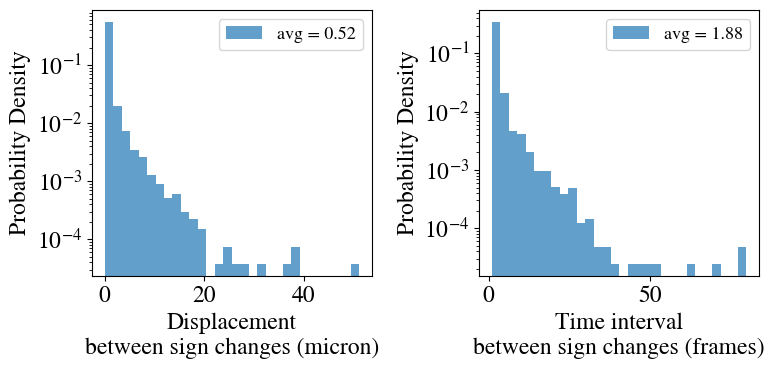

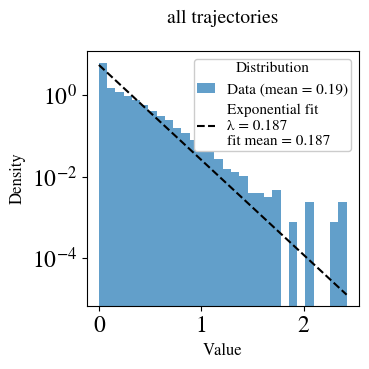


                 Fitting Results                  
Data mean:          0.1871

Exponential Distribution Parameters:
Rate (λ):           0.1871
Fit mean (1/λ):     0.1871



In [61]:
plt.figure(figsize=(8,4),layout='tight')
plt.subplot(1,2,1)
plt.hist(all_displacements, bins=30, density=True, alpha=0.7,label=f'avg = {np.mean(all_displacements):.2f}')
plt.xlabel("Displacement\nbetween sign changes (micron)")
plt.ylabel("Probability Density")
plt.legend(fontsize=13)
plt.semilogy()

plt.subplot(1,2,2)
plt.hist(all_time_intervals, bins=30, density=True, alpha=0.7,label=f'avg = {np.mean(all_time_intervals):.2f}')
plt.xlabel("Time interval\nbetween sign changes (frames)")
plt.ylabel("Probability Density")
plt.legend(fontsize=13)
plt.semilogy()
plt.show()

results_traj = plot_expon_gamma_fit(data_speed1,30,dist = 'Exponential',title='all trajectories',semilog=True)


In [9]:
dataframe_isolated = pd.read_csv('data/group-trajectories/second_wave/isolated_pairs_video1_v3_wspeeds.csv',index_col = 0)
ids_isolated = dataframe_isolated['Track ID'].unique()
computed_ids_isolated = []
for id in ids_isolated: 
    traj = dataframe_isolated[dataframe_isolated['Track ID']==id].sort_values('Frame')
    if traj['Info'].values[0] == "Isolated" and id != 16:
        computed_ids_isolated.append(id)

In [ ]:

all_displacements_isolated = []
all_time_intervals_isolated = []

for id in computed_ids_isolated: 
    traj = dataframe_isolated[dataframe_isolated['Track ID']==id].sort_values('Frame')
    # print(f'id = {id}')
    # if traj['Info'].values[0] == "Isolated" and id != 16:
    
    time = traj['Frame'].values
    x,y = traj['x (micron)'].values,traj['y (micron)'].values
    vx,vy = traj['vx'].values,traj['vy'].values
    results = persistence_intervals(x,y,vx,vy,time,if_plot=True,title3=f'id = {id}')
    all_displacements_isolated+=list(results['displacements'])
    all_time_intervals_isolated += list(results['time_intervals'])
data_speed = np.array(all_displacements_isolated)/np.array(all_time_intervals_isolated)


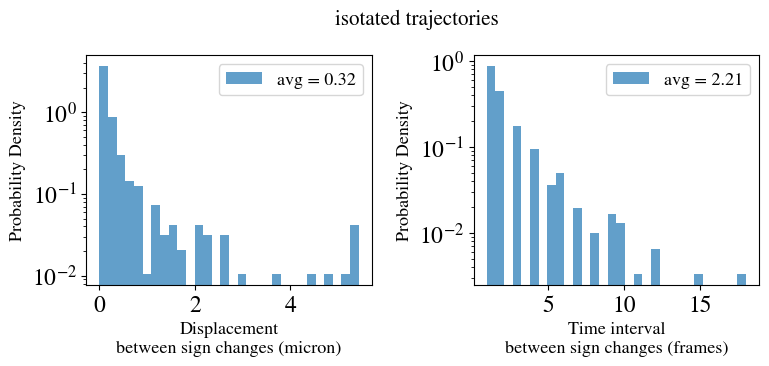

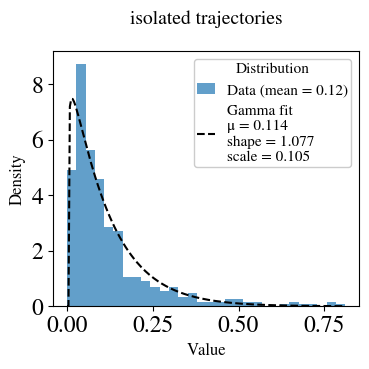


                 Fitting Results                  
Data mean:          0.1192

Gamma Distribution Parameters:
Shape (α):          1.0773
Scale (β):          0.1055
Location:           0.0057
Fit mean (αβ):      0.1136



In [62]:
plt.figure(figsize=(8,4),layout='tight')
plt.subplot(1,2,1)
plt.hist(all_displacements_isolated, bins=30, density=True, alpha=0.7,label=f'avg = {np.mean(all_displacements_isolated):.2f}')
plt.xlabel("Displacement\nbetween sign changes (micron)",fontsize=13)
plt.ylabel("Probability Density",fontsize=13)
plt.legend(fontsize=13)
plt.semilogy()

plt.subplot(1,2,2)
plt.hist(all_time_intervals_isolated, bins=30, density=True, alpha=0.7,label=f'avg = {np.mean(all_time_intervals_isolated):.2f}')
plt.xlabel("Time interval\nbetween sign changes (frames)",fontsize=13)
plt.ylabel("Probability Density",fontsize=13)
plt.legend(fontsize=13)
plt.semilogy()
plt.suptitle('isotated trajectories',y=0.93,x=0.54,fontsize=15)
plt.show()

# plt.figure(figsize=(5,5),layout='tight')
# plt.hist(data_speed, bins=30, density=True, alpha=0.7)
# plt.xlabel('length / time (micron/s)')
# plt.ylabel("Probability Density")
# plt.semilogy()
# plt.show()
results_isolated = plot_expon_gamma_fit(data_speed,30,dist = 'Gamma',title='isolated trajectories',semilog=None)
